In [1]:
%cd /data1/yokoyama/labvideo
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

/data1/yokoyama/labvideo


In [2]:
video_name = "Failures10"
prompt_v = 1
categories_v = 0

llava_preds = np.loadtxt(
    f"out/{video_name}/{video_name}_llava_p{prompt_v}_c{categories_v}.tsv",
    skiprows=1,
    dtype=str,
    delimiter="\t",
)

llava_preds[:5]

array([['1', '0.387', '56', '1', ' Pipette filler'],
       ['2', '0.831', '0', '5', ' Pasteur pipette'],
       ['3', '0.574', '79', '5', ' Pasteur pipette'],
       ['4', '0.303', '79', '1', ' Pasteur pipette'],
       ['5', '0.615', '0', '5', ' Pipette filler']], dtype='<U31')

In [3]:
categories = np.loadtxt(
    f"prompts/categories_v{categories_v}.txt", dtype=str, delimiter="\t"
)
categories
categories_dict = {i: categories[i] for i in range(len(categories))}
categories_dict

{0: 'centrifuge tube with green lid',
 1: 'culture dish',
 2: 'pasteur pipette',
 3: 'blue serological pipette',
 4: 'orange serological pipette',
 5: 'green serological pipette',
 6: 'pipette filler',
 7: 'ventilation door',
 8: 'other'}

In [4]:
llava_cls_counts = {c: 0 for c in categories_dict.values()}
for pred in llava_preds:
    llava_cls = pred[4]
    llava_cls = llava_cls.lower().strip()
    if llava_cls in llava_cls_counts:
        llava_cls_counts[llava_cls] += 1
    else:
        llava_cls_counts[llava_cls] = 1
llava_cls_counts

{'centrifuge tube with green lid': 145,
 'culture dish': 0,
 'pasteur pipette': 104,
 'blue serological pipette': 1,
 'orange serological pipette': 0,
 'green serological pipette': 2,
 'pipette filler': 97,
 'ventilation door': 1,
 'other': 0,
 'pipette': 8}

In [5]:
yolo_cls_counts = {}
for pred in llava_preds:
    yolo_cls = int(pred[2])
    if yolo_cls in yolo_cls_counts:
        yolo_cls_counts[yolo_cls] += 1
    else:
        yolo_cls_counts[yolo_cls] = 1
yolo_cls_counts = {
    k: v for k, v in sorted(yolo_cls_counts.items(), key=lambda item: item[0])
}
yolo_cls_counts

{0: 118,
 32: 32,
 38: 5,
 39: 2,
 41: 4,
 45: 2,
 56: 1,
 61: 14,
 63: 2,
 65: 11,
 67: 14,
 71: 17,
 76: 5,
 78: 22,
 79: 109}

- 0: person
- 32: sports ball
- 38: tennis racket
- 39: bottle
- 41: cup
- 45: bowl
- 56: chair
- 61: toilet
- 63: laptop
- 65: remote
- 67: cell phone
- 71: sink
- 76: scissors
- 78: hair drier
- 79: toothbrush

In [27]:
import math
def plot_images(llava_preds, cls_counts, model_type, imgs_dir, max_imgs=100):
    if model_type == "yolo":
        i_col = 2
    elif model_type == "llava":
        i_col = 4

    for cls_id in cls_counts.keys():
        if model_type == "yolo":
            preds = [p for p in llava_preds if p[i_col] == str(cls_id)]
        elif model_type == "llava":
            preds = [p for p in llava_preds if p[i_col].lower().strip() == cls_id]

        if len(preds) == 0:
            continue

        n_imgs = min(max_imgs, len(preds))
        n_col = 10
        n_row = int(math.ceil(n_imgs / 10))
        fig, axs = plt.subplots(n_row, n_col)
        ar = axs.ravel()
        for i in range(len(ar)):
            if i < len(preds):
                tid = preds[i][0]
                img_path = os.path.join(imgs_dir, f"tid{tid}.jpg")
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ar[i].imshow(img)
            ar[i].axis('off')
        print(cls_id)
        plt.show()


centrifuge tube with green lid


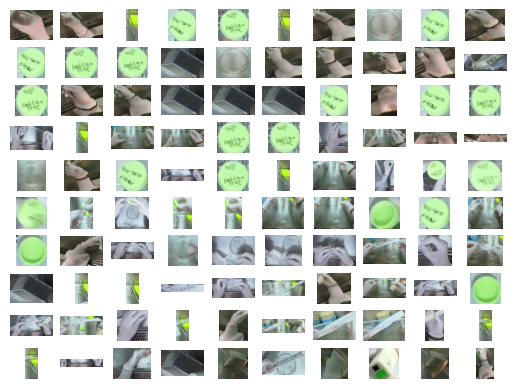

pasteur pipette


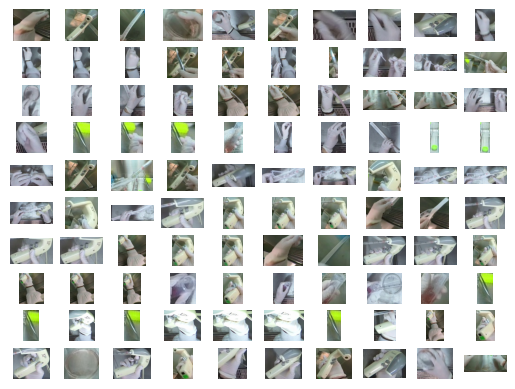

blue serological pipette


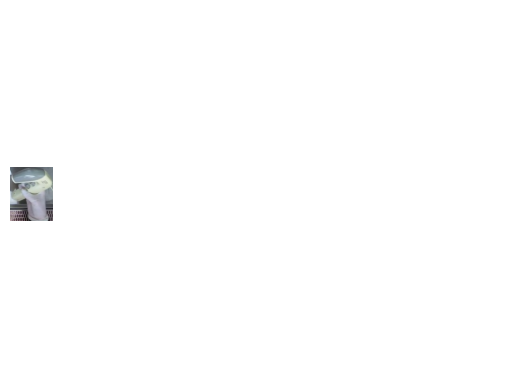

green serological pipette


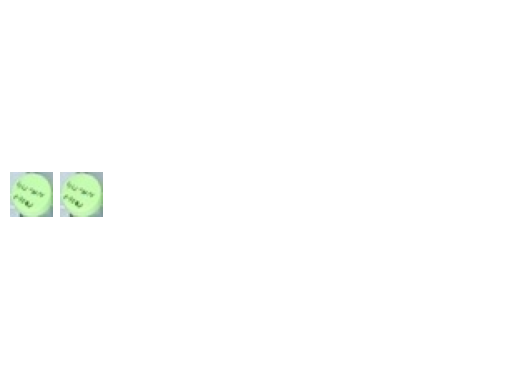

pipette filler


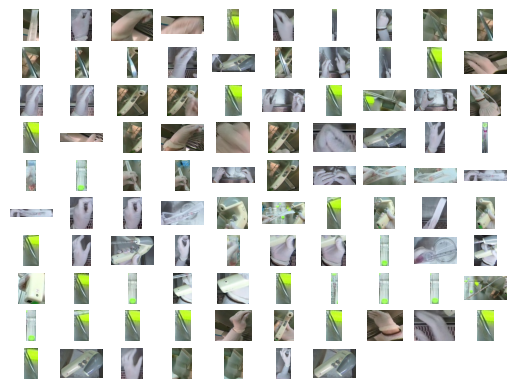

ventilation door


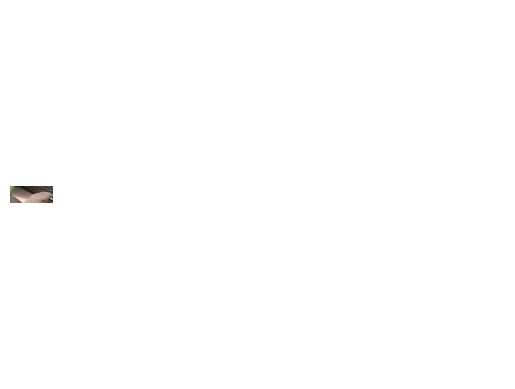

pipette


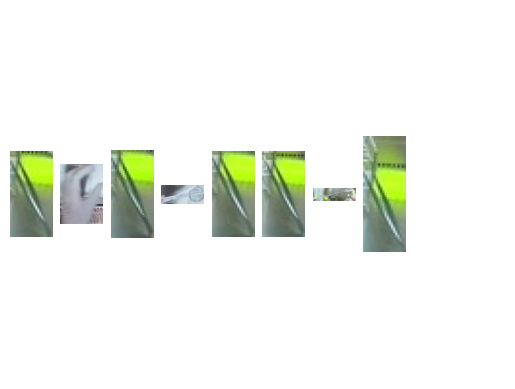

In [28]:
plot_images(llava_preds, llava_cls_counts, "llava", f"out/{video_name}/images")

0


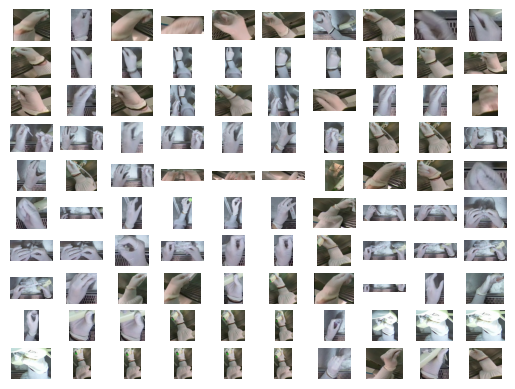

32


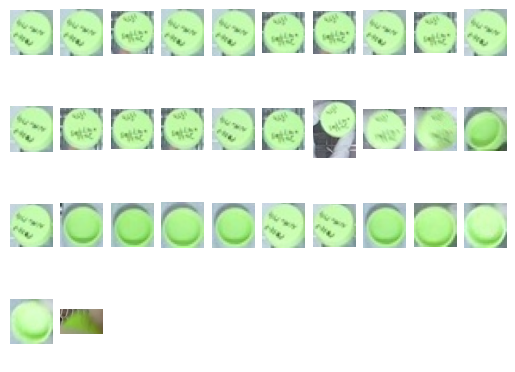

38


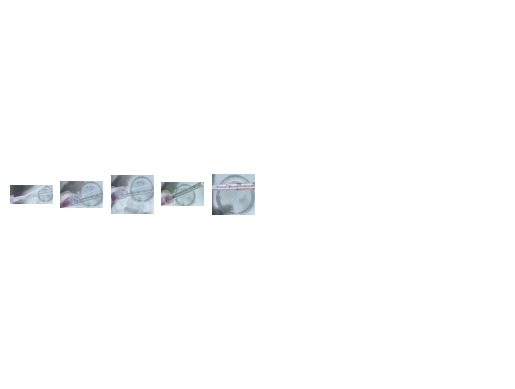

39


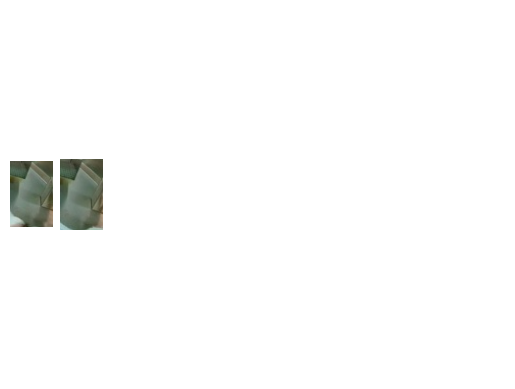

41


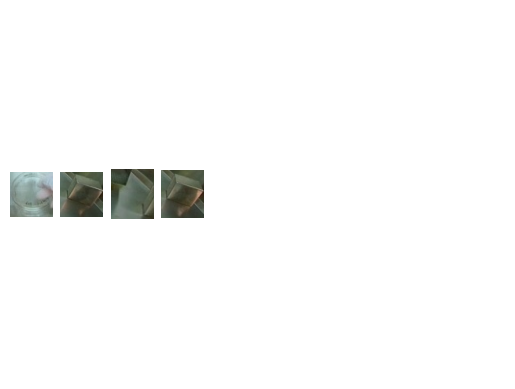

45


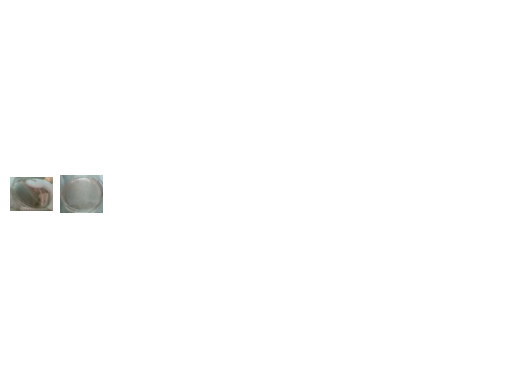

56


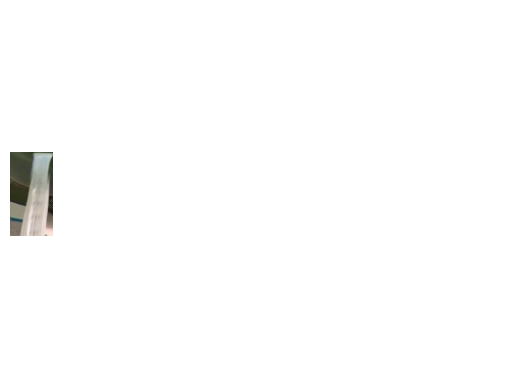

61


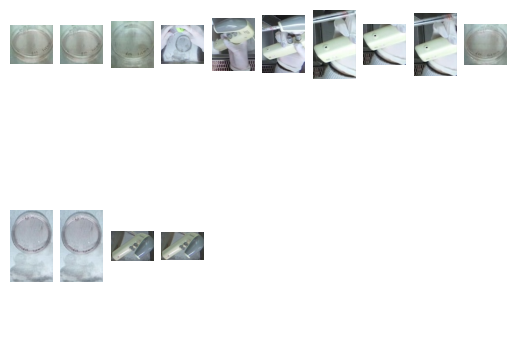

63


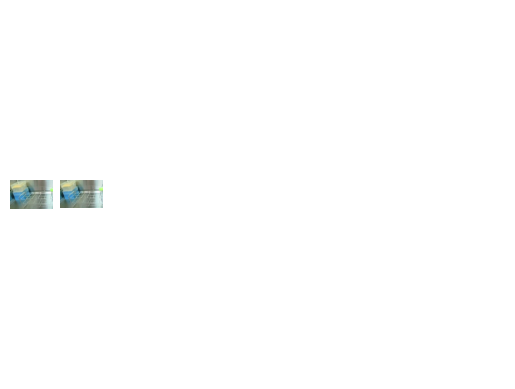

65


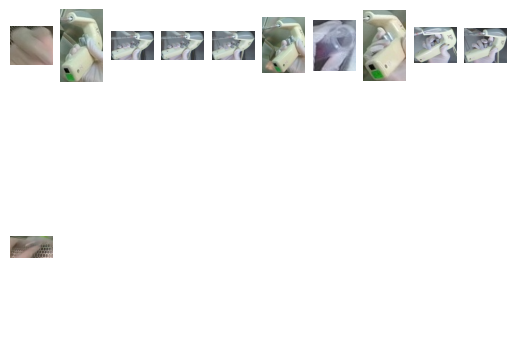

67


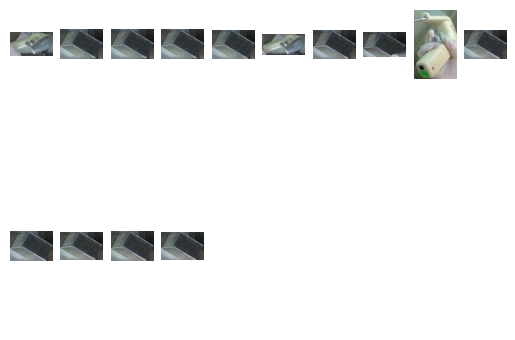

71


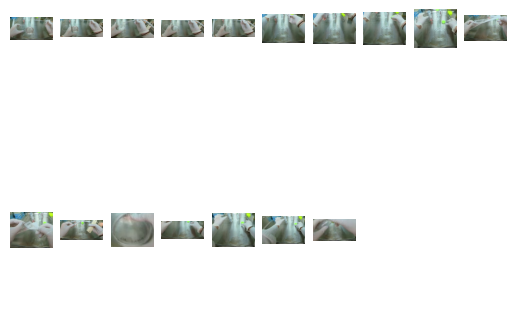

76


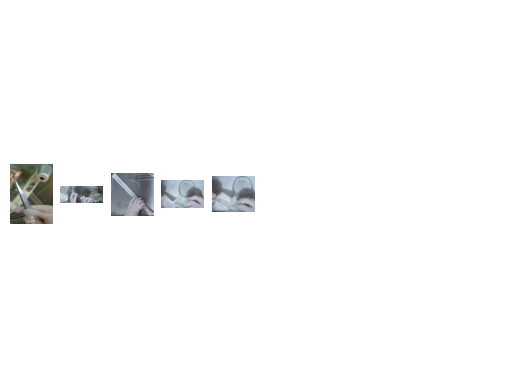

78


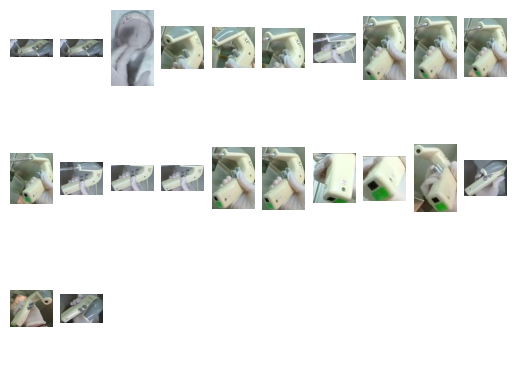

79


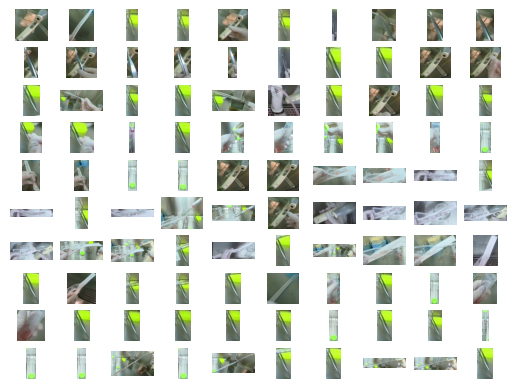

In [21]:
plot_images(llava_preds, yolo_cls_counts, "yolo", f"out/{video_name}/images")

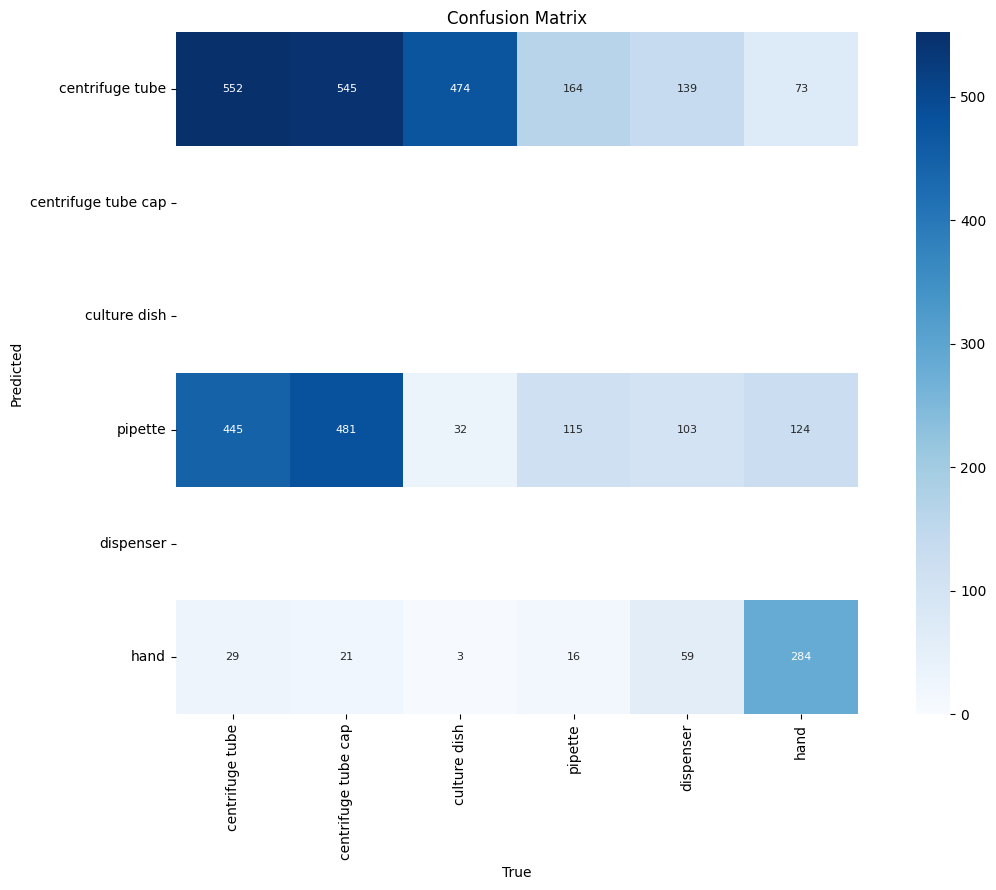

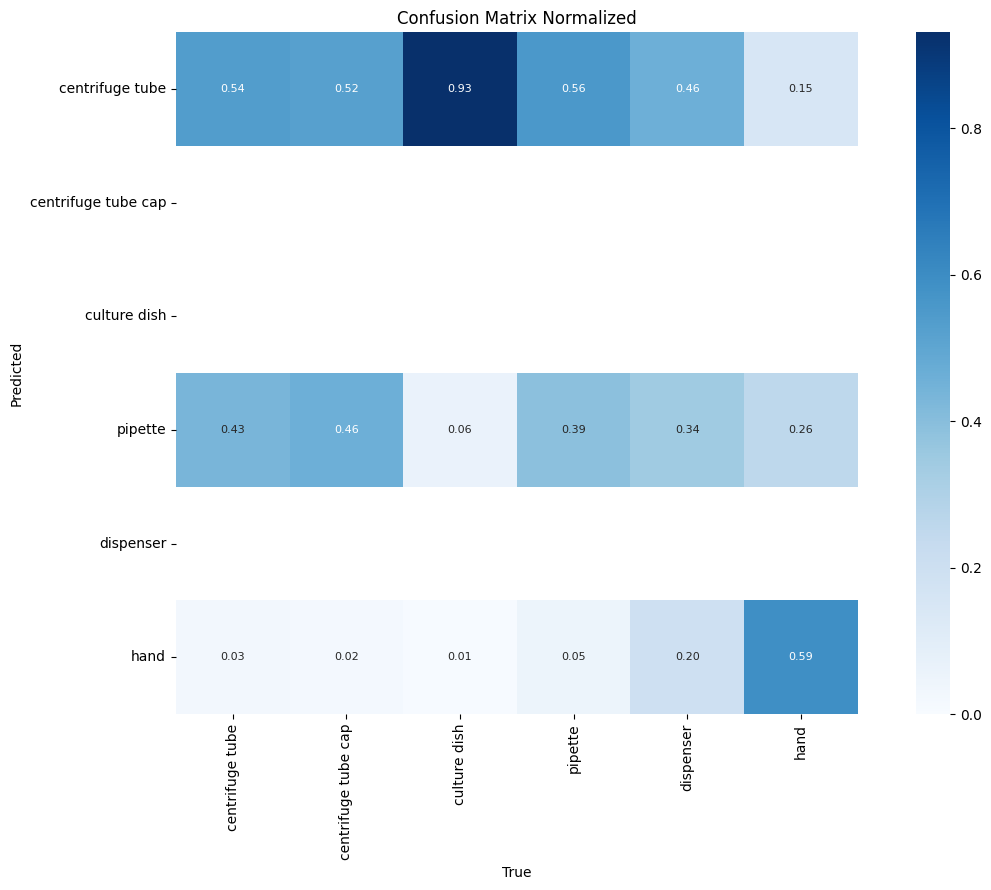

In [51]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
import seaborn


def plot_cm(cm, labels, save_path, normalize=False, on_plot=True):
    array = cm / ((cm.sum(0).reshape(1, -1) + 1e-9) if normalize else 1)  # normalize columns
    array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
    ticklabels = labels
    seaborn.heatmap(
        array,
        ax=ax,
        annot=True,
        annot_kws={"size": 8},
        cmap="Blues",
        fmt=".2f" if normalize else ".0f",
        square=True,
        vmin=0.0,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    ).set_facecolor((1, 1, 1))

    title = "Confusion Matrix" + " Normalized" * normalize
    ax.set_xlabel("True")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("Predicted")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(title)
    if normalize:
        save_path = save_path.replace(".png", "") + "_normalized.png"
    fig.savefig(save_path, dpi=250)
    if on_plot:
        plt.show()
    plt.close(fig)

# check finetuning dataset
pred = np.loadtxt("out/llava_p0_finetuning_train.tsv", dtype=str, delimiter="\t", skiprows=1)
labels = np.loadtxt("annotation/yolov8_finetuning/predefined_classes.txt", dtype=str, delimiter="\t")

cm = confusion_matrix(pred[:, 4].astype(int), pred[:, 3].astype(int)).T
path = "out/llava_p0_finetuning_train_cm.png"
# cm_plot(cm, labels, path)
plot_cm(cm, labels, path)
plot_cm(cm, labels, path, normalize=True)

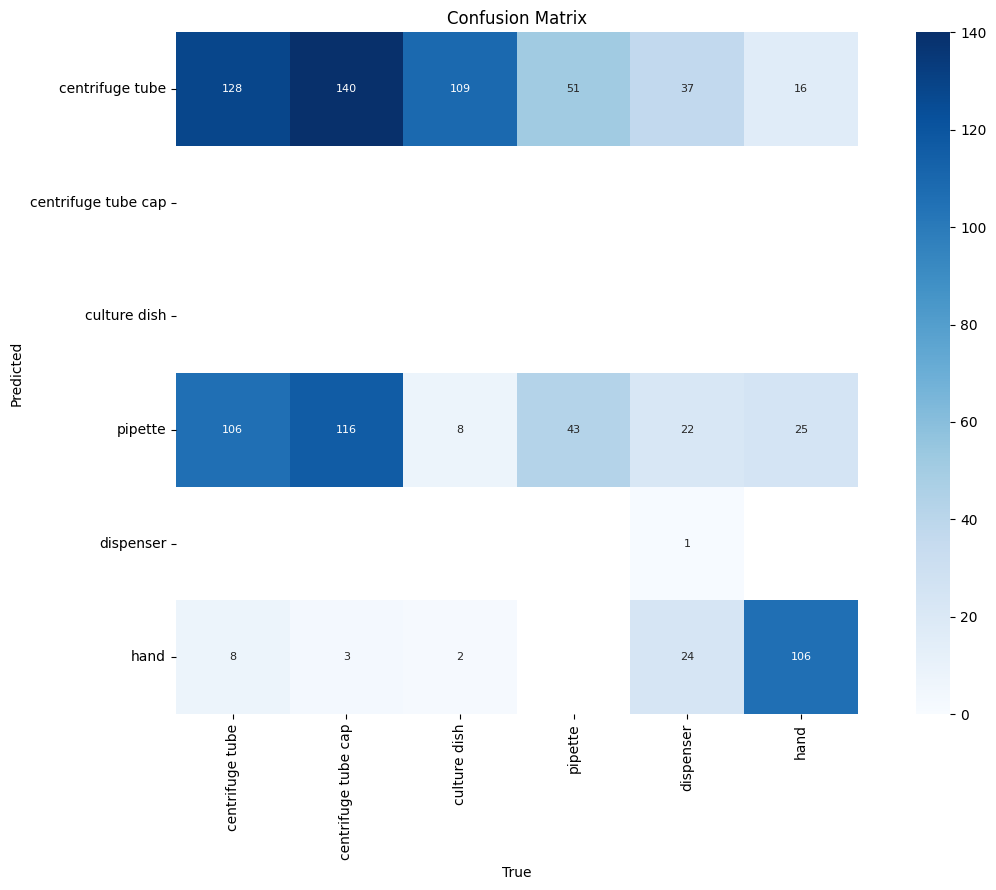

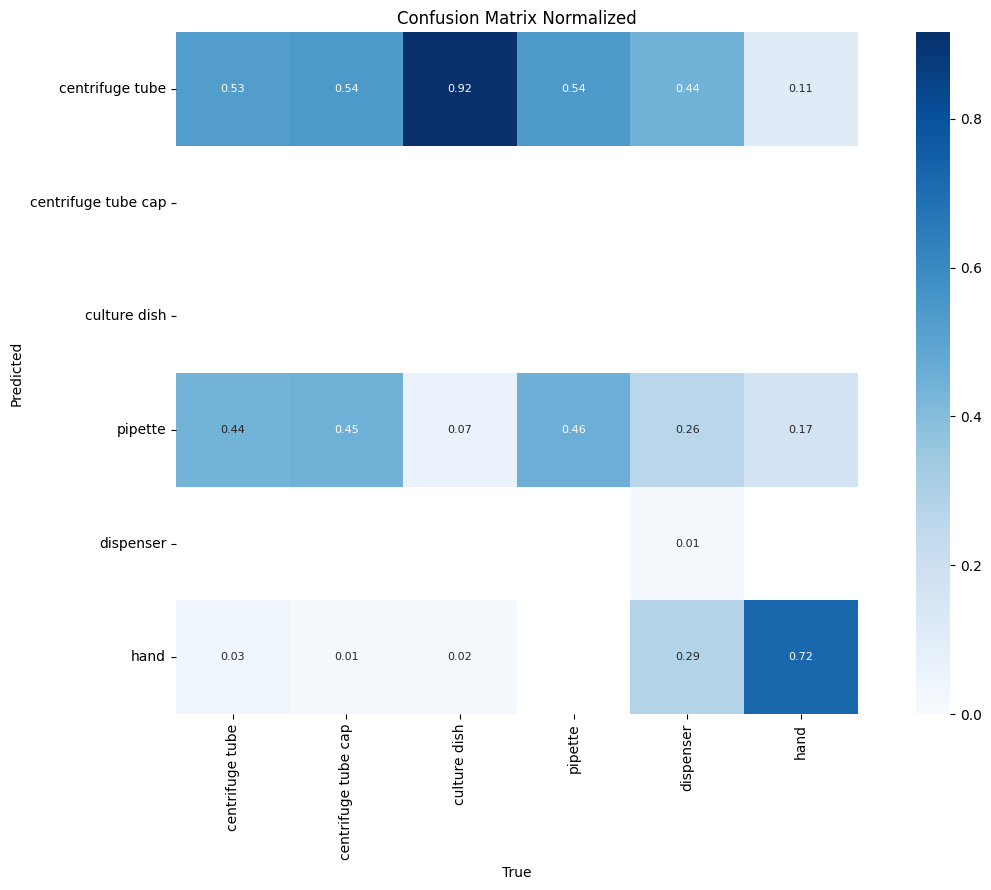

In [52]:
# check finetuning dataset
pred = np.loadtxt("out/llava_p0_finetuning_test.tsv", dtype=str, delimiter="\t", skiprows=1)
labels = np.loadtxt("annotation/yolov8_finetuning/predefined_classes.txt", dtype=str, delimiter="\t")

cm = confusion_matrix(pred[:, 4].astype(int), pred[:, 3].astype(int)).T
path = "out/llava_p0_finetuning_test_cm.png"
plot_cm(cm, labels, path)
plot_cm(cm, labels, path, normalize=True)